Hyperparameter varied- batch size

Necessary imports

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2022-07-29 03:22:33.084495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 03:22:33.084529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setting the hyperparameters of the model

In [15]:
n_epochs=10
n_layers=1
n_train = 100    # Size of the train dataset
n_test = 30     # Size of the test dataset

In [16]:
SAVE_PATH="/home/user/Desktop/impl/"
PREPROCESS=True
np.random.seed(0)
tf.random.set_seed(0)

loading the data

In [17]:
mnist_dataset=keras.datasets.mnist
(train_images,train_labels),(test_images,test_labels)=mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

test_images.shape

(30, 28, 28)

normalising the data

In [18]:
train_images=train_images/255
test_images=test_images/255
train_images.shape

(100, 28, 28)

adding extra dimension for convolution channels

In [19]:
train_images=np.array(train_images[...,tf.newaxis],requires_grad=False)
test_images=np.array(test_images[...,tf.newaxis],requires_grad=False)#requires_grad??
train_images.shape

(100, 28, 28, 1)

initilaizing a default.qubit device simulating a system of 4 qubits

In [20]:
dev = qml.device("default.qubit", wires=4)

Initialising random parameters

In [21]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))#1 x 4 returned as tensor
rand_params

tensor([[3.44829694, 4.49366732, 3.78727399, 3.42360201]], requires_grad=True)

qnode consists of a quantum function and a device on which it executes

In [22]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)#an embedding layer of local Ry rotations

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))#a random circuit of n_layers rand_params is the weight first argument of weight is the number of layers and the second argument of weights is the number of rotations

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]#measurement in the computational basis

drawing the circuit for illustration purposes with random parameters

In [23]:
drawer = qml.draw(circuit)
print(drawer([1,2,3,4]))

0: ──RY(3.14)──╭RandomLayers(M0)─┤  <Z>
1: ──RY(6.28)──├RandomLayers(M0)─┤  <Z>
2: ──RY(9.42)──├RandomLayers(M0)─┤  <Z>
3: ──RY(12.57)─╰RandomLayers(M0)─┤  <Z>


Convolution the input image with many applications of the same quantum circuit.

In [24]:
def quanv(image):
    out = np.zeros((14, 14, 4))#initilaising output image with 4 different channels

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):#the 4 expectation values are mapped into 4 different channels of a single output pixel
                out[j // 2, k // 2, c] = q_results[c]
    return out


preprocessing the train and test images as the quanvoluional layer isnt trained

In [25]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, 100), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1,30 ), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

    print(q_train_images.shape)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
100/100        
Quantum pre-processing of test images:
(100, 14, 14, 4)


In [26]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(14,14,4)))#convolution layer
    model.add(MaxPool2D(2,2))#pooling layer

    model.add(Flatten())#flattening to form 1 D array
    model.add(Dense(100,activation='relu'))# hidden layer
    model.add(Dense(10,activation='softmax'))#output layer

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    batch_size=40,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10


2022-07-29 03:32:21.409528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 03:32:21.409560: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 03:32:21.409579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (parrot): /proc/driver/nvidia/version does not exist
2022-07-29 03:32:21.410012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 - 0s - loss: 2.3286 - accuracy: 0.2100 - 357ms/epoch - 119ms/step
Epoch 2/10
3/3 - 0s - loss: 1.9152 - accuracy: 0.3400 - 14ms/epoch - 5ms/step
Epoch 3/10
3/3 - 0s - loss: 1.6191 - accuracy: 0.6000 - 15ms/epoch - 5ms/step
Epoch 4/10
3/3 - 0s - loss: 1.3287 - accuracy: 0.7800 - 18ms/epoch - 6ms/step
Epoch 5/10
3/3 - 0s - loss: 1.1081 - accuracy: 0.7900 - 24ms/epoch - 8ms/step
Epoch 6/10
3/3 - 0s - loss: 0.8795 - accuracy: 0.8700 - 18ms/epoch - 6ms/step
Epoch 7/10
3/3 - 0s - loss: 0.6936 - accuracy: 0.9600 - 17ms/epoch - 6ms/step
Epoch 8/10
3/3 - 0s - loss: 0.5410 - accuracy: 0.9600 - 23ms/epoch - 8ms/step
Epoch 9/10
3/3 - 0s - loss: 0.4220 - accuracy: 0.9700 - 27ms/epoch - 9ms/step
Epoch 10/10
3/3 - 0s - loss: 0.3331 - accuracy: 0.9800 - 20ms/epoch - 7ms/step


Evaluation of model

In [36]:
q_model.evaluate(q_test_images,test_labels)#5

63/63 [==============================] - 0s 3ms/step - loss: 0.1855 - accuracy: 0.9595


[0.18551400303840637, 0.9595000147819519]

In [38]:
q_model.evaluate(q_test_images,test_labels)#10

63/63 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9690


[0.11710798740386963, 0.968999981880188]

In [40]:
q_model.evaluate(q_test_images,test_labels)#15

63/63 [==============================] - 0s 4ms/step - loss: 0.1365 - accuracy: 0.9620


[0.13652342557907104, 0.9620000123977661]

In [42]:
q_model.evaluate(q_test_images,test_labels)#20

63/63 [==============================] - 0s 4ms/step - loss: 0.1382 - accuracy: 0.9645


[0.13819913566112518, 0.9645000100135803]

In [44]:
q_model.evaluate(q_test_images,test_labels)#25

63/63 [==============================] - 0s 4ms/step - loss: 0.1448 - accuracy: 0.9590


[0.1447574645280838, 0.9589999914169312]

In [46]:
q_model.evaluate(q_test_images,test_labels)#30

63/63 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9675


[0.11267229169607162, 0.9674999713897705]

In [48]:
q_model.evaluate(q_test_images,test_labels)#35

63/63 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9610


[0.12314474582672119, 0.9610000252723694]

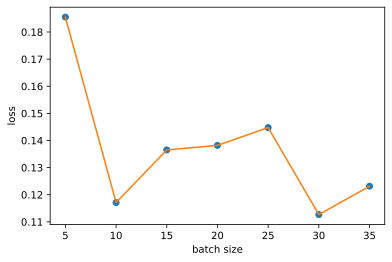

In [29]:
import numpy as np
import matplotlib.pyplot as plt
x=np.array([5,10,15,20,25,30,35])
y=np.array([0.18551400303840637,0.11710798740386963,0.13652342557907104,0.13819913566112518,0.1447574645280838,0.11267229169607162,0.12314474582672119])

plt.plot(x,y,'o')
plt.plot(x,y)
plt.xlabel("batch size")
plt.ylabel("loss")

plt.show()

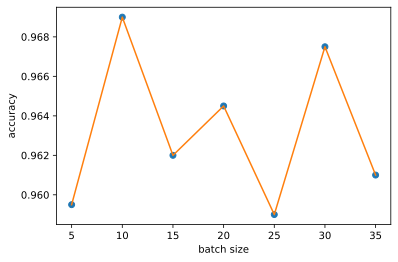

In [30]:
import numpy as np
import matplotlib.pyplot as plt
x=np.array([5,10,15,20,25,30,35])
y=np.array([0.9595000147819519,0.968999981880188,0.9620000123977661,0.9645000100135803,0.9589999914169312,0.9674999713897705,0.9610000252723694])

plt.plot(x,y,'o')
plt.plot(x,y)
plt.xlabel("batch size")
plt.ylabel("accuracy")

plt.show()